In [1]:
cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
from src.kinetic_model import KineticModel, modelSpace_to_modelParams, modelParams_to_modelSpace
from src.neural_network_builder import KineticEigenModelBuilder
from src.runAmber_kinn_NESS import get_data
from amber.architect import pmbga
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import yaml
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import seaborn as sns

2022-05-14 12:21:55.795547: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /cm/shared/sw/pkg/devel/gcc/7.4.0/lib:/cm/shared/apps/slurm/current/lib64/slurm:/cm/shared/apps/slurm/current/lib64
2022-05-14 12:21:55.795572: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Matplotlib created a temporary config/cache directory at /tmp/matplotlib-lfy90oy2 because the default path (/home/zzhang/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


detected tf2 - using compatibility mode
0.1.2


In [3]:
model_params = yaml.load(open("/mnt/home/alamson/ceph/DATA/CRISPR/KineticSims/22-05-12_cas9_kinn_deplete/cas9_kinn_deplete_params.yaml"), Loader=yaml.Loader)
model_params = modelParams_to_modelSpace(model_params)
kinn = KineticModel(model_params)
(x_train, y_train), (x_test, y_test) = get_data()

In [4]:
mb = KineticEigenModelBuilder(
        kinn=kinn,
        #output_op=lambda: tf.keras.layers.Lambda(lambda x: tf.reshape(x[:,1], (-1,1)), name="output_slice"),
        output_op=lambda: tf.keras.layers.Lambda(lambda x: tf.math.log(tf.reshape(- x[:,1], (-1,1))), name="output_slice"),
        n_channels=9,
        n_feats=50,
        replace_conv_by_fc=False)
mb.build(optimizer=tf.keras.optimizers.Adam(lr=0.01))
x_train_b = mb.blockify_seq_ohe(x_train)
x_test_b = mb.blockify_seq_ohe(x_test)


2022-05-14 12:22:01.372663: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-05-14 12:22:01.372720: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (worker2021): /proc/driver/nvidia/version does not exist
2022-05-14 12:22:01.374523: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


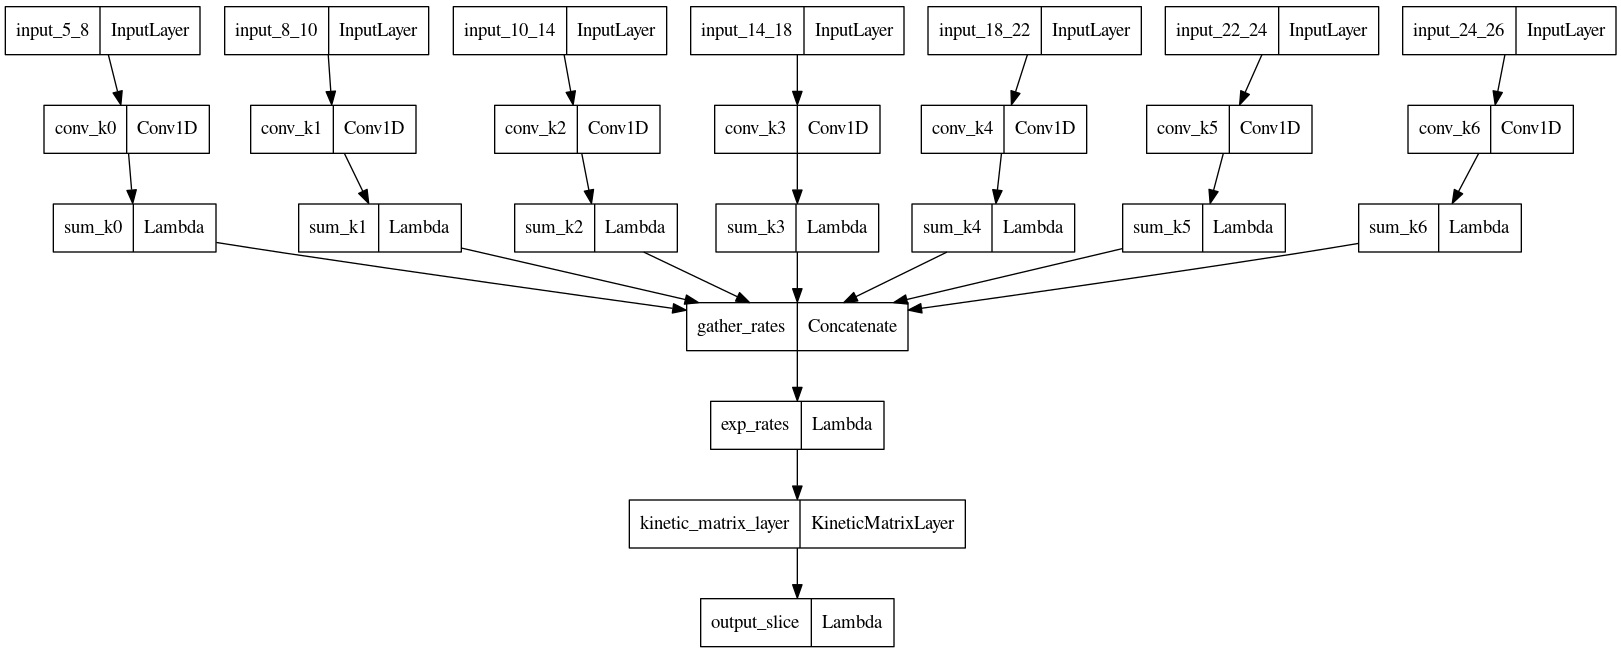

In [5]:
model = mb.model
tf.keras.utils.plot_model(model)

In [6]:
checkpointer = ModelCheckpoint(filepath="bestmodel.h5", mode='min', verbose=0, save_best_only=True,
                       save_weights_only=True)
earlystopper = EarlyStopping(
    monitor="val_loss",
    mode='min',
    patience=5,
    verbose=0)

hist = model.fit(x_train_b, y_train,
          batch_size=128,
          validation_data=(x_test_b, y_test),
          callbacks=[checkpointer, earlystopper],
          epochs=150, verbose=1)

Train on 3543 samples, validate on 886 samples
Epoch 1/150
3543/3543 [==============================] - 2s 426us/sample - loss: 3.6957 - val_loss: 1.1681
Epoch 2/150
3543/3543 [==============================] - 1s 191us/sample - loss: 1.0775 - val_loss: 0.9843
Epoch 3/150
3543/3543 [==============================] - 1s 204us/sample - loss: 0.8547 - val_loss: 0.7881
Epoch 4/150
3543/3543 [==============================] - 1s 209us/sample - loss: 0.7239 - val_loss: 0.6858
Epoch 5/150
3543/3543 [==============================] - 1s 206us/sample - loss: 0.6316 - val_loss: 0.5921
Epoch 6/150
3543/3543 [==============================] - 1s 213us/sample - loss: 0.5498 - val_loss: 0.5130
Epoch 7/150
3543/3543 [==============================] - 1s 215us/sample - loss: 0.4825 - val_loss: 0.4467
Epoch 8/150
3543/3543 [==============================] - 1s 215us/sample - loss: 0.4247 - val_loss: 0.3873
Epoch 9/150
3543/3543 [==============================] - 1s 206us/sample - loss: 0.3681 - val_los

In [7]:
model.load_weights("bestmodel.h5")
y_hat = model.predict(x_test_b).flatten()
test_reward = ss.pearsonr(np.exp(y_hat), np.exp(y_test))[0]
print(test_reward)

0.9743629025494874


Text(0.5, 1.0, 'Pred Eigval vs Fit\npcc=0.974')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


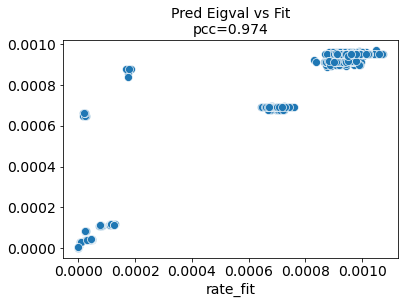

In [8]:
%matplotlib inline
ax = sns.scatterplot(x=np.exp(y_test), y=np.exp(y_hat))
ax.set_title('Pred Eigval vs Fit\npcc=%.3f' % test_reward)

Text(0.5, 1.0, 'Obs Eigval vs Fit\npcc=0.996')

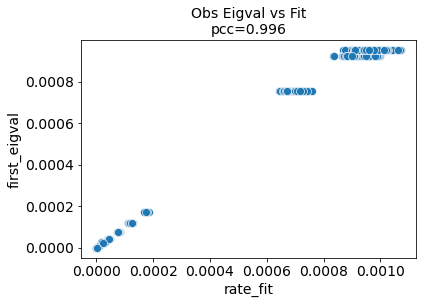

In [9]:
df = pd.read_table('/mnt/home/alamson/ceph/DATA/CRISPR/KineticSims/22-05-12_cas9_kinn_deplete/cas9_kinn_deplete_full_data.tsv')
y_eig = - df.loc[y_test.index]['first_eigval']
ax = sns.scatterplot(x=np.exp(y_test), y=y_eig)
ax.set_title('Obs Eigval vs Fit\npcc=%.3f' % ss.pearsonr(y_eig, np.exp(y_test))[0])

In [10]:
sub_model = tf.keras.Model(inputs=mb.model.inputs, outputs=mb.model.layers[-2].output)
print(sub_model.predict(x_test_b))

[[ 0.0000000e+00 -9.5337274e-04]
 [ 0.0000000e+00 -9.5421571e-04]
 [ 0.0000000e+00 -9.5337274e-04]
 ...
 [ 0.0000000e+00 -6.9041457e-04]
 [ 0.0000000e+00 -9.5337274e-04]
 [ 0.0000000e+00 -4.9601304e-06]]


In [11]:
df.loc[y_test.index]['first_eigval']

3170   -9.519810e-04
2603   -9.519809e-04
975    -9.519810e-04
2203   -4.312197e-05
508    -9.519810e-04
            ...     
2199   -9.519809e-04
599    -9.256779e-04
329    -7.571739e-04
1273   -9.519810e-04
4098   -3.323684e-07
Name: first_eigval, Length: 886, dtype: float64